<a href="https://colab.research.google.com/github/emmanuel-olateju/EmotiSpot/blob/main/data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!kaggle datasets download -d khan1803115/eeg-dataset-for-emotion-recognition
!mkdir -p datasets/khan1803115
!unzip eeg-dataset-for-emotion-recognition.zip -d datasets/khan1803115/
!rm eeg-dataset-for-emotion-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/khan1803115/eeg-dataset-for-emotion-recognition
License(s): Apache 2.0
 95% 172M/181M [00:00<00:00, 179MB/s]
100% 181M/181M [00:01<00:00, 182MB/s]
Archive:  eeg-dataset-for-emotion-recognition.zip
  inflating: datasets/khan1803115/Data/S01G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S01G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S02G4AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G1AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G2AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G3AllChannels.csv  
  inflating: datasets/khan1803115/Data/S03G4AllChannels.csv  
  inflating: d

In [2]:
import os

import numpy as np
import pandas as pd
!pip install mne
import mne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 21.1 MB/s eta 0:00:00


In [3]:
import joblib
# from google.colab import files

def save_artifact(artifact,name):
  joblib.dump(artifact,name)
  # files.download(name)


## Data Loading

In [4]:
khan_dataset_dir = "datasets/khan1803115/"
valence = pd.read_csv(khan_dataset_dir+"valence_normalize.csv")
arousal = pd.read_csv(khan_dataset_dir+"arousal_normalize.csv")
data = [pd.read_csv(khan_dataset_dir+"Data/"+file) for file in os.listdir(khan_dataset_dir+"Data/")]

channels = data[0].columns[:-2]
label_columns = data[0].columns[-2:]
fs = 128

In [5]:
eeg_data = np.array([data_[channels][:38000] for data_ in data])
valence_arousal_values = np.array([data_[label_columns].mean() for data_ in data])
eeg_data.shape, valence_arousal_values.shape

((100, 38000, 14), (100, 2))

In [6]:
# Make use of 1280 samples for an epoch with 0 samples overlapping between succesive epochs
epoch_starting_points = np.arange(0,38252,1280-0)[:-4]

eeg_epochs = []

for i in range(len(data)):
    epochs = []
    for epoch_starting_point in epoch_starting_points:
        epochs.append(eeg_data[i,epoch_starting_point:epoch_starting_point+1280,:])

    eeg_epochs.append(epochs)

eeg_epochs = np.array(eeg_epochs)

eeg_epochs.shape

(100, 26, 1280, 14)

In [7]:
epoch_targets = []

for i in range(len(data)):
  targets = [valence_arousal_values[i]]*26
  epoch_targets.append(targets)

epoch_targets = np.array(epoch_targets)

epoch_targets.shape

(100, 26, 2)

In [8]:
eeg_epochs = eeg_epochs.reshape(2600,1280,14)
epoch_targets = epoch_targets.reshape(2600,2)

eeg_epochs.shape, epoch_targets.shape

((2600, 1280, 14), (2600, 2))

In [9]:
# save_artifact(eeg_epochs,"EEG_DATA.np")

## Preprocessing

In [10]:
lowcut = 1
highcut = 45

filtered_eeg_epochs = np.empty((2600,1280,14))

for e,epoch in enumerate(eeg_epochs):
  filtered = mne.filter.filter_data(epoch.T,fs,lowcut,highcut,verbose=0)
  filtered_eeg_epochs[e,:,:] = filtered.T

filtered_eeg_epochs.shape

(2600, 1280, 14)

In [11]:
# save_artifact(filtered_eeg_epochs,"FILTERED_EEG_DATA.np")
# save_artifact(epoch_targets,"EEG_VALENCE_AROUSAL_TARGETS.np")

## Make Dataloader

In [33]:
import random

import torch
import torch.nn as nn
import torch.functional as F
import torch.optim as optim

# Set the device
device_ = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Current Device: {device_}")

# Set the device globally
# torch.set_default_device(device_)

Current Device: cpu


In [34]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):

  def __init__(self, features, targets, transform=None, device__="cpu"):
    self.features = torch.tensor(features,device=device__)
    self.targets = torch.tensor(targets,device=device__)
    self.transform = transform

  def __len__(self):
    return len(self.features)

  def __getitem__(self,idx):
    feature = self.features[idx,::]
    target = self.targets[idx]
    if self.transform:
      feature = self.transform(feature)
    return feature, target

In [108]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

random.seed(120)
torch.manual_seed(120)

X, y = filtered_eeg_epochs, epoch_targets

# feature_scaler = MinMaxScaler()
# y = feature_scaler.fit_transform(y)


X_train, X_, y_train, y_ = train_test_split(X, y, test_size=0.20, random_state=100)
X_test, X_val, y_test, y_val = train_test_split(X_, y_, test_size=0.5, random_state=100)

for i in range(len(X_train)):
  scaler = StandardScaler()
  X_train[i,::] = scaler.fit_transform(X_train[i,::])

for i in range(len(X_test)):
  scaler = StandardScaler()
  X_test[i,::] = scaler.fit_transform(X_test[i,::])

for i in range(len(X_val)):
  scaler = StandardScaler()
  X_val[i,::] = scaler.fit_transform(X_val[i,::])

feature_scaler = MinMaxScaler()
y_train = feature_scaler.fit_transform(y_train)
y_test = feature_scaler.transform(y_test)
y_val = feature_scaler.transform(y_val)

print(f" Train Size :({X_train.shape}, {y_train.shape}) | Test Size : ({X_test.shape}, {y_test.shape}) | Validation Size: ({X_val.shape}, {y_val.shape})")

train_batch_size = 204
shuffle_ = True
num_workers_ = 5

# Make Train Dataloader
train_dataset = CustomDataset(X_train.astype(float),y_train.astype(float))
train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=shuffle_, num_workers=num_workers_)

# Make Validation Dataloader
val_batch_size = 34
val_dataset = CustomDataset(X_val.astype(float),y_val.astype(float))
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=shuffle_, num_workers=num_workers_)

X_train = torch.tensor(X_train).to(torch.float)
y_train = torch.tensor(y_train).to(torch.float)
X_train = X_train.to(device_)
y_train = y_train.to(device_)

X_test = torch.tensor(X_test).to(torch.float)
y_test = torch.tensor(y_test).to(torch.float)
X_test = X_test.to(device_)
y_test = y_test.to(device_)

X_val = torch.tensor(X_val).to(torch.float)
y_val = torch.tensor(y_val).to(torch.float)
X_val = X_val.to(device_)
y_val = y_val.to(device_)

 Train Size :((2080, 1280, 14), (2080, 2)) | Test Size : ((260, 1280, 14), (260, 2)) | Validation Size: ((260, 1280, 14), (260, 2))


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Modelling

In [109]:
class mlp(nn.Module):

  def __init__(self):
    super(mlp,self).__init__()

    self.fc1 = nn.Sequential(
        nn.Dropout(0.5),
        nn.Linear(1280*14,1000),
        nn.Sigmoid(),
        nn.Dropout(0.5),
        nn.Linear(1000,1000),
        nn.Sigmoid(),
        nn.Linear(1000,100),
        nn.Sigmoid(),
        nn.Linear(100,2),
        nn.Sigmoid(),
        nn.Linear(2,2),
        nn.ReLU()
    )


  def forward(self,x):

    x = x.view(x.size()[0],-1)
    x = self.fc1(x.to(torch.float32))

    return x

class cnn(nn.Module):

  def __init__(self):
    super(cnn,self).__init__()

    self.conv = nn.Sequential(
      nn.Dropout(0.1),
      nn.BatchNorm1d(14),
      nn.Conv1d(14,14,kernel_size=64,stride=32,padding=0), # OUTPUT: C=14, L=39
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=3,stride=2), # OUTPUT: C=14, L=19
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
      nn.Conv1d(14,14,kernel_size=2,stride=1,padding=0), #OUTPUT: C=14, L=18
      nn.ReLU(),
      nn.AvgPool1d(kernel_size=5,stride=1), # OUTPUT: C=14, L=14
      nn.BatchNorm1d(14),
      nn.Dropout(0.1),
    )

    self.fc = nn.Sequential(
        # nn.Dropout(0.05),
        nn.Linear(14*14,98),
        nn.Tanh(),
        nn.BatchNorm1d(98),
        nn.Linear(98,50),
        nn.Tanh(),
        nn.BatchNorm1d(50),
        nn.Linear(50,25),
        nn.Tanh(),
        nn.BatchNorm1d(25),
        nn.Linear(25,2),
        nn.LeakyReLU()
    )

  def forward(self,x):
    x = torch.transpose(x,1,2)
    x = self.conv(x)
    x = x.view(x.size()[0],-1)
    x = self.fc(x)

    return x


def r_squared(predicted, target):
    # Compute the mean of the target tensor
    target_mean = torch.mean(target)

    # Compute the total sum of squares (TSS)
    tss = torch.sum((target - target_mean) ** 2)

    # Compute the residual sum of squares (RSS)
    rss = torch.sum((target - predicted) ** 2)

    # Compute R-squared
    r_squared = 1 - (rss / tss)

    return r_squared


In [104]:
# torch.backends.cuda.cufft_plan_cache[0].max_size = 0

  0%|          | 1/600 [00:00<07:23,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 0/600 | loss: 1.55 |  validation loss: 1.55 | learning rate: [0.001]


  0%|          | 2/600 [00:01<07:30,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 1/600 | loss: 1.52 |  validation loss: 1.55 | learning rate: [0.001]


  0%|          | 3/600 [00:02<07:17,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 2/600 | loss: 1.50 |  validation loss: 1.54 | learning rate: [0.001]


  1%|          | 4/600 [00:03<07:43,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 3/600 | loss: 1.48 |  validation loss: 1.50 | learning rate: [0.001]


  1%|          | 5/600 [00:04<08:26,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 4/600 | loss: 1.44 |  validation loss: 1.48 | learning rate: [0.001]


  1%|          | 6/600 [00:05<09:09,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 5/600 | loss: 1.43 |  validation loss: 1.46 | learning rate: [0.001]


  1%|          | 7/600 [00:06<09:27,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 6/600 | loss: 1.40 |  validation loss: 1.43 | learning rate: [0.001]


  1%|▏         | 8/600 [00:06<08:56,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 7/600 | loss: 1.37 |  validation loss: 1.41 | learning rate: [0.001]


  2%|▏         | 9/600 [00:07<08:20,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 8/600 | loss: 1.36 |  validation loss: 1.39 | learning rate: [0.001]


  2%|▏         | 10/600 [00:08<07:52,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 9/600 | loss: 1.34 |  validation loss: 1.37 | learning rate: [0.001]


  2%|▏         | 11/600 [00:09<07:36,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 10/600 | loss: 1.33 |  validation loss: 1.35 | learning rate: [0.001]


  2%|▏         | 12/600 [00:09<07:26,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 11/600 | loss: 1.31 |  validation loss: 1.31 | learning rate: [0.001]


  2%|▏         | 13/600 [00:10<07:19,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 12/600 | loss: 1.29 |  validation loss: 1.30 | learning rate: [0.001]


  2%|▏         | 14/600 [00:11<07:12,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 13/600 | loss: 1.27 |  validation loss: 1.28 | learning rate: [0.001]


  2%|▎         | 15/600 [00:11<07:08,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 14/600 | loss: 1.25 |  validation loss: 1.26 | learning rate: [0.001]


  3%|▎         | 16/600 [00:12<07:09,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 15/600 | loss: 1.23 |  validation loss: 1.24 | learning rate: [0.001]


  3%|▎         | 17/600 [00:13<07:09,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 16/600 | loss: 1.22 |  validation loss: 1.22 | learning rate: [0.001]


  3%|▎         | 18/600 [00:14<07:10,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 17/600 | loss: 1.20 |  validation loss: 1.20 | learning rate: [0.001]


  3%|▎         | 19/600 [00:14<07:13,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 18/600 | loss: 1.19 |  validation loss: 1.20 | learning rate: [0.001]


  3%|▎         | 20/600 [00:15<07:05,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 19/600 | loss: 1.18 |  validation loss: 1.19 | learning rate: [0.001]


  4%|▎         | 21/600 [00:16<07:06,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 20/600 | loss: 1.17 |  validation loss: 1.18 | learning rate: [0.001]


  4%|▎         | 22/600 [00:17<07:46,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 21/600 | loss: 1.15 |  validation loss: 1.15 | learning rate: [0.001]


  4%|▍         | 23/600 [00:18<08:20,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 22/600 | loss: 1.14 |  validation loss: 1.16 | learning rate: [0.001]


  4%|▍         | 24/600 [00:19<08:47,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 23/600 | loss: 1.13 |  validation loss: 1.14 | learning rate: [0.001]


  4%|▍         | 25/600 [00:20<08:43,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 24/600 | loss: 1.11 |  validation loss: 1.11 | learning rate: [0.001]


  4%|▍         | 26/600 [00:21<08:09,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 25/600 | loss: 1.11 |  validation loss: 1.09 | learning rate: [0.001]


  4%|▍         | 27/600 [00:21<07:46,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 26/600 | loss: 1.09 |  validation loss: 1.08 | learning rate: [0.001]


  5%|▍         | 28/600 [00:22<07:34,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 27/600 | loss: 1.08 |  validation loss: 1.08 | learning rate: [0.001]


  5%|▍         | 29/600 [00:23<07:23,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 28/600 | loss: 1.07 |  validation loss: 1.06 | learning rate: [0.001]


  5%|▌         | 30/600 [00:23<07:12,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 29/600 | loss: 1.06 |  validation loss: 1.06 | learning rate: [0.001]


  5%|▌         | 31/600 [00:24<07:09,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 30/600 | loss: 1.05 |  validation loss: 1.06 | learning rate: [0.001]


  5%|▌         | 32/600 [00:25<07:03,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 31/600 | loss: 1.05 |  validation loss: 1.04 | learning rate: [0.001]


  6%|▌         | 33/600 [00:26<06:59,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 32/600 | loss: 1.03 |  validation loss: 1.03 | learning rate: [0.001]


  6%|▌         | 34/600 [00:26<06:56,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 33/600 | loss: 1.02 |  validation loss: 1.04 | learning rate: [0.001]


  6%|▌         | 35/600 [00:27<06:50,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 34/600 | loss: 1.01 |  validation loss: 1.04 | learning rate: [0.001]


  6%|▌         | 36/600 [00:28<06:46,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 35/600 | loss: 1.01 |  validation loss: 1.04 | learning rate: [0.001]


  6%|▌         | 37/600 [00:29<06:52,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 36/600 | loss: 0.99 |  validation loss: 1.00 | learning rate: [0.001]


  6%|▋         | 38/600 [00:29<06:48,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 37/600 | loss: 0.99 |  validation loss: 0.98 | learning rate: [0.001]


  6%|▋         | 39/600 [00:30<07:29,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 38/600 | loss: 0.98 |  validation loss: 1.00 | learning rate: [0.001]


  7%|▋         | 40/600 [00:31<08:00,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 39/600 | loss: 0.97 |  validation loss: 1.00 | learning rate: [0.001]


  7%|▋         | 41/600 [00:32<08:23,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 40/600 | loss: 0.96 |  validation loss: 0.96 | learning rate: [0.001]


  7%|▋         | 42/600 [00:33<08:33,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 41/600 | loss: 0.95 |  validation loss: 0.96 | learning rate: [0.001]


  7%|▋         | 43/600 [00:34<07:55,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 42/600 | loss: 0.94 |  validation loss: 0.94 | learning rate: [0.001]


  7%|▋         | 44/600 [00:35<07:33,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 43/600 | loss: 0.94 |  validation loss: 0.93 | learning rate: [0.001]


  8%|▊         | 45/600 [00:35<07:17,  1.27it/s]

----------------------------------------------------------------------------------
Epoch: 44/600 | loss: 0.93 |  validation loss: 0.94 | learning rate: [0.001]


  8%|▊         | 46/600 [00:36<07:06,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 45/600 | loss: 0.92 |  validation loss: 0.91 | learning rate: [0.001]


  8%|▊         | 47/600 [00:37<06:57,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 46/600 | loss: 0.91 |  validation loss: 0.91 | learning rate: [0.001]


  8%|▊         | 48/600 [00:37<06:50,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 47/600 | loss: 0.91 |  validation loss: 0.90 | learning rate: [0.001]


  8%|▊         | 49/600 [00:38<06:41,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 48/600 | loss: 0.90 |  validation loss: 0.90 | learning rate: [0.001]


  8%|▊         | 50/600 [00:39<06:36,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 49/600 | loss: 0.90 |  validation loss: 0.89 | learning rate: [0.001]


  8%|▊         | 51/600 [00:40<06:34,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 50/600 | loss: 0.89 |  validation loss: 0.89 | learning rate: [0.001]


  9%|▊         | 52/600 [00:40<06:38,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 51/600 | loss: 0.88 |  validation loss: 0.89 | learning rate: [0.001]


  9%|▉         | 53/600 [00:41<06:38,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 52/600 | loss: 0.87 |  validation loss: 0.87 | learning rate: [0.001]


  9%|▉         | 54/600 [00:42<06:32,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 53/600 | loss: 0.87 |  validation loss: 0.86 | learning rate: [0.001]


  9%|▉         | 55/600 [00:42<06:29,  1.40it/s]

----------------------------------------------------------------------------------
Epoch: 54/600 | loss: 0.86 |  validation loss: 0.89 | learning rate: [0.001]


  9%|▉         | 56/600 [00:43<06:29,  1.40it/s]

----------------------------------------------------------------------------------
Epoch: 55/600 | loss: 0.85 |  validation loss: 0.88 | learning rate: [0.001]


 10%|▉         | 57/600 [00:44<07:16,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 56/600 | loss: 0.84 |  validation loss: 0.86 | learning rate: [0.001]


 10%|▉         | 58/600 [00:45<07:47,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 57/600 | loss: 0.84 |  validation loss: 0.85 | learning rate: [0.001]


 10%|▉         | 59/600 [00:46<08:09,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 58/600 | loss: 0.83 |  validation loss: 0.83 | learning rate: [0.001]


 10%|█         | 60/600 [00:47<08:11,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 59/600 | loss: 0.83 |  validation loss: 0.83 | learning rate: [0.001]


 10%|█         | 61/600 [00:48<07:43,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 60/600 | loss: 0.82 |  validation loss: 0.83 | learning rate: [0.001]


 10%|█         | 62/600 [00:49<07:21,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 61/600 | loss: 0.82 |  validation loss: 0.81 | learning rate: [0.001]


 10%|█         | 63/600 [00:49<07:06,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 62/600 | loss: 0.81 |  validation loss: 0.82 | learning rate: [0.001]


 11%|█         | 64/600 [00:50<06:55,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 63/600 | loss: 0.80 |  validation loss: 0.80 | learning rate: [0.001]


 11%|█         | 65/600 [00:51<06:48,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 64/600 | loss: 0.80 |  validation loss: 0.79 | learning rate: [0.001]


 11%|█         | 66/600 [00:52<06:42,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 65/600 | loss: 0.79 |  validation loss: 0.79 | learning rate: [0.001]


 11%|█         | 67/600 [00:52<06:33,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 66/600 | loss: 0.79 |  validation loss: 0.79 | learning rate: [0.001]


 11%|█▏        | 68/600 [00:53<06:27,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 67/600 | loss: 0.78 |  validation loss: 0.78 | learning rate: [0.001]


 12%|█▏        | 69/600 [00:54<06:22,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 68/600 | loss: 0.77 |  validation loss: 0.79 | learning rate: [0.001]


 12%|█▏        | 70/600 [00:54<06:32,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 69/600 | loss: 0.77 |  validation loss: 0.80 | learning rate: [0.001]


 12%|█▏        | 71/600 [00:55<06:27,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 70/600 | loss: 0.76 |  validation loss: 0.83 | learning rate: [0.001]


 12%|█▏        | 72/600 [00:56<06:27,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 71/600 | loss: 0.76 |  validation loss: 0.76 | learning rate: [0.001]


 12%|█▏        | 73/600 [00:57<06:23,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 72/600 | loss: 0.75 |  validation loss: 0.76 | learning rate: [0.001]


 12%|█▏        | 74/600 [00:57<06:47,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 73/600 | loss: 0.75 |  validation loss: 0.74 | learning rate: [0.001]


 12%|█▎        | 75/600 [00:59<07:34,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 74/600 | loss: 0.74 |  validation loss: 0.75 | learning rate: [0.001]


 13%|█▎        | 76/600 [01:00<08:12,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 75/600 | loss: 0.73 |  validation loss: 0.75 | learning rate: [0.001]


 13%|█▎        | 77/600 [01:01<08:26,  1.03it/s]

----------------------------------------------------------------------------------
Epoch: 76/600 | loss: 0.73 |  validation loss: 0.74 | learning rate: [0.001]


 13%|█▎        | 78/600 [01:01<07:44,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 77/600 | loss: 0.72 |  validation loss: 0.74 | learning rate: [0.001]


 13%|█▎        | 79/600 [01:02<07:14,  1.20it/s]

----------------------------------------------------------------------------------
Epoch: 78/600 | loss: 0.72 |  validation loss: 0.73 | learning rate: [0.001]


 13%|█▎        | 80/600 [01:03<06:54,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 79/600 | loss: 0.71 |  validation loss: 0.72 | learning rate: [0.001]


 14%|█▎        | 81/600 [01:04<06:46,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 80/600 | loss: 0.71 |  validation loss: 0.72 | learning rate: [0.001]


 14%|█▎        | 82/600 [01:04<06:38,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 81/600 | loss: 0.70 |  validation loss: 0.70 | learning rate: [0.001]


 14%|█▍        | 83/600 [01:05<06:34,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 82/600 | loss: 0.70 |  validation loss: 0.70 | learning rate: [0.001]


 14%|█▍        | 84/600 [01:06<06:27,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 83/600 | loss: 0.69 |  validation loss: 0.69 | learning rate: [0.001]


 14%|█▍        | 85/600 [01:06<06:21,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 84/600 | loss: 0.69 |  validation loss: 0.70 | learning rate: [0.001]


 14%|█▍        | 86/600 [01:07<06:14,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 85/600 | loss: 0.68 |  validation loss: 0.73 | learning rate: [0.001]


 14%|█▍        | 87/600 [01:08<06:14,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 86/600 | loss: 0.68 |  validation loss: 0.69 | learning rate: [0.001]


 15%|█▍        | 88/600 [01:09<06:18,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 87/600 | loss: 0.67 |  validation loss: 0.68 | learning rate: [0.001]


 15%|█▍        | 89/600 [01:09<06:11,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 88/600 | loss: 0.67 |  validation loss: 0.68 | learning rate: [0.001]


 15%|█▌        | 90/600 [01:10<06:06,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 89/600 | loss: 0.66 |  validation loss: 0.66 | learning rate: [0.001]


 15%|█▌        | 91/600 [01:11<06:18,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 90/600 | loss: 0.66 |  validation loss: 0.67 | learning rate: [0.001]


 15%|█▌        | 92/600 [01:12<07:01,  1.20it/s]

----------------------------------------------------------------------------------
Epoch: 91/600 | loss: 0.65 |  validation loss: 0.66 | learning rate: [0.001]


 16%|█▌        | 93/600 [01:13<07:28,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 92/600 | loss: 0.65 |  validation loss: 0.66 | learning rate: [0.001]


 16%|█▌        | 94/600 [01:14<07:47,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 93/600 | loss: 0.64 |  validation loss: 0.69 | learning rate: [0.001]


 16%|█▌        | 95/600 [01:15<07:26,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 94/600 | loss: 0.64 |  validation loss: 0.66 | learning rate: [0.001]


 16%|█▌        | 96/600 [01:15<07:04,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 95/600 | loss: 0.64 |  validation loss: 0.67 | learning rate: [0.001]


 16%|█▌        | 97/600 [01:16<06:43,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 96/600 | loss: 0.63 |  validation loss: 0.66 | learning rate: [0.001]


 16%|█▋        | 98/600 [01:17<06:26,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 97/600 | loss: 0.63 |  validation loss: 0.63 | learning rate: [0.001]


 16%|█▋        | 99/600 [01:18<06:15,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 98/600 | loss: 0.63 |  validation loss: 0.64 | learning rate: [0.001]


 17%|█▋        | 100/600 [01:18<06:09,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 99/600 | loss: 0.62 |  validation loss: 0.65 | learning rate: [0.001]


 17%|█▋        | 101/600 [01:19<06:04,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 100/600 | loss: 0.61 |  validation loss: 0.63 | learning rate: [0.001]


 17%|█▋        | 102/600 [01:20<06:06,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 101/600 | loss: 0.61 |  validation loss: 0.62 | learning rate: [0.001]


 17%|█▋        | 103/600 [01:20<06:03,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 102/600 | loss: 0.60 |  validation loss: 0.61 | learning rate: [0.001]


 17%|█▋        | 104/600 [01:21<05:59,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 103/600 | loss: 0.61 |  validation loss: 0.61 | learning rate: [0.001]


 18%|█▊        | 105/600 [01:22<06:01,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 104/600 | loss: 0.60 |  validation loss: 0.61 | learning rate: [0.001]


 18%|█▊        | 106/600 [01:23<05:58,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 105/600 | loss: 0.59 |  validation loss: 0.60 | learning rate: [0.001]


 18%|█▊        | 107/600 [01:23<06:03,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 106/600 | loss: 0.59 |  validation loss: 0.60 | learning rate: [0.001]


 18%|█▊        | 108/600 [01:24<06:08,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 107/600 | loss: 0.59 |  validation loss: 0.60 | learning rate: [0.001]


 18%|█▊        | 109/600 [01:25<06:44,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 108/600 | loss: 0.58 |  validation loss: 0.58 | learning rate: [0.001]


 18%|█▊        | 110/600 [01:26<07:10,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 109/600 | loss: 0.58 |  validation loss: 0.58 | learning rate: [0.001]


 18%|█▊        | 111/600 [01:27<07:34,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 110/600 | loss: 0.57 |  validation loss: 0.59 | learning rate: [0.001]


 19%|█▊        | 112/600 [01:28<07:29,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 111/600 | loss: 0.56 |  validation loss: 0.59 | learning rate: [0.001]


 19%|█▉        | 113/600 [01:29<06:55,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 112/600 | loss: 0.56 |  validation loss: 0.59 | learning rate: [0.001]


 19%|█▉        | 114/600 [01:30<06:37,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 113/600 | loss: 0.56 |  validation loss: 0.57 | learning rate: [0.001]


 19%|█▉        | 115/600 [01:30<06:21,  1.27it/s]

----------------------------------------------------------------------------------
Epoch: 114/600 | loss: 0.55 |  validation loss: 0.56 | learning rate: [0.001]


 19%|█▉        | 116/600 [01:31<06:08,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 115/600 | loss: 0.55 |  validation loss: 0.58 | learning rate: [0.001]


 20%|█▉        | 117/600 [01:32<06:02,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 116/600 | loss: 0.54 |  validation loss: 0.57 | learning rate: [0.001]


 20%|█▉        | 118/600 [01:32<05:58,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 117/600 | loss: 0.54 |  validation loss: 0.56 | learning rate: [0.001]


 20%|█▉        | 119/600 [01:33<05:59,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 118/600 | loss: 0.54 |  validation loss: 0.54 | learning rate: [0.001]


 20%|██        | 120/600 [01:34<05:55,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 119/600 | loss: 0.54 |  validation loss: 0.55 | learning rate: [0.001]


 20%|██        | 121/600 [01:35<05:54,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 120/600 | loss: 0.53 |  validation loss: 0.54 | learning rate: [0.001]


 20%|██        | 122/600 [01:35<05:55,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 121/600 | loss: 0.53 |  validation loss: 0.53 | learning rate: [0.001]


 20%|██        | 123/600 [01:36<05:58,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 122/600 | loss: 0.52 |  validation loss: 0.53 | learning rate: [0.001]


 21%|██        | 124/600 [01:37<05:58,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 123/600 | loss: 0.52 |  validation loss: 0.54 | learning rate: [0.001]


 21%|██        | 125/600 [01:38<05:51,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 124/600 | loss: 0.52 |  validation loss: 0.53 | learning rate: [0.001]


 21%|██        | 126/600 [01:39<06:25,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 125/600 | loss: 0.51 |  validation loss: 0.53 | learning rate: [0.001]


 21%|██        | 127/600 [01:40<06:50,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 126/600 | loss: 0.51 |  validation loss: 0.53 | learning rate: [0.001]


 21%|██▏       | 128/600 [01:41<07:16,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 127/600 | loss: 0.51 |  validation loss: 0.52 | learning rate: [0.001]


 22%|██▏       | 129/600 [01:42<07:14,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 128/600 | loss: 0.50 |  validation loss: 0.52 | learning rate: [0.001]


 22%|██▏       | 130/600 [01:42<06:45,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 129/600 | loss: 0.50 |  validation loss: 0.51 | learning rate: [0.001]


 22%|██▏       | 131/600 [01:43<06:30,  1.20it/s]

----------------------------------------------------------------------------------
Epoch: 130/600 | loss: 0.49 |  validation loss: 0.51 | learning rate: [0.001]


 22%|██▏       | 132/600 [01:44<06:18,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 131/600 | loss: 0.49 |  validation loss: 0.50 | learning rate: [0.001]


 22%|██▏       | 133/600 [01:45<06:03,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 132/600 | loss: 0.49 |  validation loss: 0.50 | learning rate: [0.001]


 22%|██▏       | 134/600 [01:45<05:53,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 133/600 | loss: 0.48 |  validation loss: 0.50 | learning rate: [0.001]


 22%|██▎       | 135/600 [01:46<05:48,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 134/600 | loss: 0.48 |  validation loss: 0.49 | learning rate: [0.001]


 23%|██▎       | 136/600 [01:47<05:40,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 135/600 | loss: 0.47 |  validation loss: 0.49 | learning rate: [0.001]


 23%|██▎       | 137/600 [01:47<05:41,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 136/600 | loss: 0.47 |  validation loss: 0.50 | learning rate: [0.001]


 23%|██▎       | 138/600 [01:48<05:37,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 137/600 | loss: 0.47 |  validation loss: 0.48 | learning rate: [0.001]


 23%|██▎       | 139/600 [01:49<05:34,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 138/600 | loss: 0.46 |  validation loss: 0.47 | learning rate: [0.001]


 23%|██▎       | 140/600 [01:50<05:34,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 139/600 | loss: 0.46 |  validation loss: 0.47 | learning rate: [0.001]


 24%|██▎       | 141/600 [01:50<05:32,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 140/600 | loss: 0.46 |  validation loss: 0.47 | learning rate: [0.001]


 24%|██▎       | 142/600 [01:51<05:30,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 141/600 | loss: 0.46 |  validation loss: 0.46 | learning rate: [0.001]


 24%|██▍       | 143/600 [01:52<05:41,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 142/600 | loss: 0.45 |  validation loss: 0.45 | learning rate: [0.001]


 24%|██▍       | 144/600 [01:53<06:18,  1.20it/s]

----------------------------------------------------------------------------------
Epoch: 143/600 | loss: 0.45 |  validation loss: 0.48 | learning rate: [0.001]


 24%|██▍       | 145/600 [01:54<06:47,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 144/600 | loss: 0.44 |  validation loss: 0.46 | learning rate: [0.001]


 24%|██▍       | 146/600 [01:55<07:03,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 145/600 | loss: 0.44 |  validation loss: 0.45 | learning rate: [0.001]


 24%|██▍       | 147/600 [01:56<06:48,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 146/600 | loss: 0.44 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▍       | 148/600 [01:56<06:24,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 147/600 | loss: 0.44 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▍       | 149/600 [01:57<06:03,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 148/600 | loss: 0.43 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▌       | 150/600 [01:58<05:46,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 149/600 | loss: 0.43 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▌       | 151/600 [01:59<05:34,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 150/600 | loss: 0.42 |  validation loss: 0.44 | learning rate: [0.001]


 25%|██▌       | 152/600 [01:59<05:25,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 151/600 | loss: 0.42 |  validation loss: 0.43 | learning rate: [0.001]


 26%|██▌       | 153/600 [02:00<05:25,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 152/600 | loss: 0.42 |  validation loss: 0.43 | learning rate: [0.001]


 26%|██▌       | 154/600 [02:01<05:26,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 153/600 | loss: 0.42 |  validation loss: 0.43 | learning rate: [0.001]


 26%|██▌       | 155/600 [02:01<05:24,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 154/600 | loss: 0.41 |  validation loss: 0.42 | learning rate: [0.001]


 26%|██▌       | 156/600 [02:02<05:21,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 155/600 | loss: 0.41 |  validation loss: 0.42 | learning rate: [0.001]


 26%|██▌       | 157/600 [02:03<05:21,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 156/600 | loss: 0.40 |  validation loss: 0.42 | learning rate: [0.001]


 26%|██▋       | 158/600 [02:04<05:25,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 157/600 | loss: 0.40 |  validation loss: 0.41 | learning rate: [0.001]


 26%|██▋       | 159/600 [02:04<05:23,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 158/600 | loss: 0.40 |  validation loss: 0.41 | learning rate: [0.001]


 27%|██▋       | 160/600 [02:05<05:18,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 159/600 | loss: 0.40 |  validation loss: 0.41 | learning rate: [0.001]


 27%|██▋       | 161/600 [02:06<05:39,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 160/600 | loss: 0.39 |  validation loss: 0.41 | learning rate: [0.001]


 27%|██▋       | 162/600 [02:07<06:08,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 161/600 | loss: 0.39 |  validation loss: 0.40 | learning rate: [0.001]


 27%|██▋       | 163/600 [02:08<06:27,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 162/600 | loss: 0.39 |  validation loss: 0.39 | learning rate: [0.001]


 27%|██▋       | 164/600 [02:09<06:40,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 163/600 | loss: 0.38 |  validation loss: 0.40 | learning rate: [0.001]


 28%|██▊       | 165/600 [02:10<06:17,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 164/600 | loss: 0.38 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 166/600 [02:10<05:57,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 165/600 | loss: 0.38 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 167/600 [02:11<05:40,  1.27it/s]

----------------------------------------------------------------------------------
Epoch: 166/600 | loss: 0.37 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 168/600 [02:12<05:27,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 167/600 | loss: 0.37 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 169/600 [02:12<05:17,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 168/600 | loss: 0.37 |  validation loss: 0.39 | learning rate: [0.001]


 28%|██▊       | 170/600 [02:13<05:12,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 169/600 | loss: 0.37 |  validation loss: 0.38 | learning rate: [0.001]


 28%|██▊       | 171/600 [02:14<05:09,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 170/600 | loss: 0.36 |  validation loss: 0.38 | learning rate: [0.001]


 29%|██▊       | 172/600 [02:15<05:07,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 171/600 | loss: 0.36 |  validation loss: 0.38 | learning rate: [0.001]


 29%|██▉       | 173/600 [02:15<05:13,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 172/600 | loss: 0.36 |  validation loss: 0.38 | learning rate: [0.001]


 29%|██▉       | 174/600 [02:16<05:14,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 173/600 | loss: 0.36 |  validation loss: 0.37 | learning rate: [0.001]


 29%|██▉       | 175/600 [02:17<05:10,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 174/600 | loss: 0.35 |  validation loss: 0.37 | learning rate: [0.001]


 29%|██▉       | 176/600 [02:18<05:12,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 175/600 | loss: 0.35 |  validation loss: 0.36 | learning rate: [0.001]


 30%|██▉       | 177/600 [02:18<05:10,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 176/600 | loss: 0.35 |  validation loss: 0.36 | learning rate: [0.001]


 30%|██▉       | 178/600 [02:19<05:11,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 177/600 | loss: 0.35 |  validation loss: 0.36 | learning rate: [0.001]


 30%|██▉       | 179/600 [02:20<05:43,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 178/600 | loss: 0.34 |  validation loss: 0.37 | learning rate: [0.001]


 30%|███       | 180/600 [02:21<06:10,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 179/600 | loss: 0.34 |  validation loss: 0.35 | learning rate: [0.001]


 30%|███       | 181/600 [02:22<06:25,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 180/600 | loss: 0.34 |  validation loss: 0.35 | learning rate: [0.001]


 30%|███       | 182/600 [02:23<06:29,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 181/600 | loss: 0.34 |  validation loss: 0.34 | learning rate: [0.001]


 30%|███       | 183/600 [02:24<06:04,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 182/600 | loss: 0.33 |  validation loss: 0.34 | learning rate: [0.001]


 31%|███       | 184/600 [02:25<05:44,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 183/600 | loss: 0.33 |  validation loss: 0.35 | learning rate: [0.001]


 31%|███       | 185/600 [02:25<05:33,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 184/600 | loss: 0.33 |  validation loss: 0.35 | learning rate: [0.001]


 31%|███       | 186/600 [02:26<05:25,  1.27it/s]

----------------------------------------------------------------------------------
Epoch: 185/600 | loss: 0.32 |  validation loss: 0.34 | learning rate: [0.001]


 31%|███       | 187/600 [02:27<05:18,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 186/600 | loss: 0.32 |  validation loss: 0.33 | learning rate: [0.001]


 31%|███▏      | 188/600 [02:27<05:10,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 187/600 | loss: 0.32 |  validation loss: 0.33 | learning rate: [0.001]


 32%|███▏      | 189/600 [02:28<05:03,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 188/600 | loss: 0.32 |  validation loss: 0.32 | learning rate: [0.001]


 32%|███▏      | 190/600 [02:29<04:58,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 189/600 | loss: 0.32 |  validation loss: 0.32 | learning rate: [0.001]


 32%|███▏      | 191/600 [02:30<04:55,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 190/600 | loss: 0.31 |  validation loss: 0.34 | learning rate: [0.001]


 32%|███▏      | 192/600 [02:30<04:52,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 191/600 | loss: 0.31 |  validation loss: 0.32 | learning rate: [0.001]


 32%|███▏      | 193/600 [02:31<04:51,  1.40it/s]

----------------------------------------------------------------------------------
Epoch: 192/600 | loss: 0.31 |  validation loss: 0.32 | learning rate: [0.001]


 32%|███▏      | 194/600 [02:32<04:53,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 193/600 | loss: 0.31 |  validation loss: 0.31 | learning rate: [0.001]


 32%|███▎      | 195/600 [02:32<04:53,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 194/600 | loss: 0.30 |  validation loss: 0.31 | learning rate: [0.001]


 33%|███▎      | 196/600 [02:33<05:04,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 195/600 | loss: 0.30 |  validation loss: 0.31 | learning rate: [0.001]


 33%|███▎      | 197/600 [02:34<05:34,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 196/600 | loss: 0.30 |  validation loss: 0.32 | learning rate: [0.001]


 33%|███▎      | 198/600 [02:35<05:56,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 197/600 | loss: 0.30 |  validation loss: 0.31 | learning rate: [0.001]


 33%|███▎      | 199/600 [02:36<06:14,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 198/600 | loss: 0.29 |  validation loss: 0.30 | learning rate: [0.001]


 33%|███▎      | 200/600 [02:37<06:00,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 199/600 | loss: 0.29 |  validation loss: 0.30 | learning rate: [0.001]


 34%|███▎      | 201/600 [02:38<05:38,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 200/600 | loss: 0.29 |  validation loss: 0.30 | learning rate: [0.001]


 34%|███▎      | 202/600 [02:39<05:28,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 201/600 | loss: 0.29 |  validation loss: 0.31 | learning rate: [0.001]


 34%|███▍      | 203/600 [02:39<05:19,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 202/600 | loss: 0.29 |  validation loss: 0.30 | learning rate: [0.001]


 34%|███▍      | 204/600 [02:40<05:08,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 203/600 | loss: 0.28 |  validation loss: 0.31 | learning rate: [0.001]


 34%|███▍      | 205/600 [02:41<04:58,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 204/600 | loss: 0.28 |  validation loss: 0.29 | learning rate: [0.001]


 34%|███▍      | 206/600 [02:42<05:01,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 205/600 | loss: 0.28 |  validation loss: 0.29 | learning rate: [0.001]


 34%|███▍      | 207/600 [02:42<04:56,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 206/600 | loss: 0.28 |  validation loss: 0.29 | learning rate: [0.001]


 35%|███▍      | 208/600 [02:43<04:59,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 207/600 | loss: 0.27 |  validation loss: 0.29 | learning rate: [0.001]


 35%|███▍      | 209/600 [02:44<04:53,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 208/600 | loss: 0.27 |  validation loss: 0.29 | learning rate: [0.001]


 35%|███▌      | 210/600 [02:45<04:53,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 209/600 | loss: 0.27 |  validation loss: 0.29 | learning rate: [0.001]


 35%|███▌      | 211/600 [02:45<04:52,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 210/600 | loss: 0.27 |  validation loss: 0.28 | learning rate: [0.001]


 35%|███▌      | 212/600 [02:46<04:50,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 211/600 | loss: 0.27 |  validation loss: 0.29 | learning rate: [0.001]


 36%|███▌      | 213/600 [02:47<04:59,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 212/600 | loss: 0.26 |  validation loss: 0.27 | learning rate: [0.001]


 36%|███▌      | 214/600 [02:48<05:29,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 213/600 | loss: 0.26 |  validation loss: 0.29 | learning rate: [0.001]


 36%|███▌      | 215/600 [02:49<05:49,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 214/600 | loss: 0.26 |  validation loss: 0.27 | learning rate: [0.001]


 36%|███▌      | 216/600 [02:50<06:01,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 215/600 | loss: 0.26 |  validation loss: 0.27 | learning rate: [0.001]


 36%|███▌      | 217/600 [02:51<05:37,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 216/600 | loss: 0.26 |  validation loss: 0.28 | learning rate: [0.001]


 36%|███▋      | 218/600 [02:52<05:19,  1.20it/s]

----------------------------------------------------------------------------------
Epoch: 217/600 | loss: 0.25 |  validation loss: 0.28 | learning rate: [0.001]


 36%|███▋      | 219/600 [02:52<05:03,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 218/600 | loss: 0.25 |  validation loss: 0.27 | learning rate: [0.001]


 37%|███▋      | 220/600 [02:53<04:53,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 219/600 | loss: 0.25 |  validation loss: 0.26 | learning rate: [0.001]


 37%|███▋      | 221/600 [02:54<04:48,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 220/600 | loss: 0.25 |  validation loss: 0.25 | learning rate: [0.001]


 37%|███▋      | 222/600 [02:54<04:42,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 221/600 | loss: 0.25 |  validation loss: 0.27 | learning rate: [0.001]


 37%|███▋      | 223/600 [02:55<04:41,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 222/600 | loss: 0.25 |  validation loss: 0.26 | learning rate: [0.001]


 37%|███▋      | 224/600 [02:56<04:38,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 223/600 | loss: 0.24 |  validation loss: 0.25 | learning rate: [0.001]


 38%|███▊      | 225/600 [02:57<04:36,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 224/600 | loss: 0.24 |  validation loss: 0.26 | learning rate: [0.001]


 38%|███▊      | 226/600 [02:57<04:30,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 225/600 | loss: 0.24 |  validation loss: 0.25 | learning rate: [0.001]


 38%|███▊      | 227/600 [02:58<04:28,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 226/600 | loss: 0.24 |  validation loss: 0.25 | learning rate: [0.001]


 38%|███▊      | 228/600 [02:59<04:32,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 227/600 | loss: 0.24 |  validation loss: 0.26 | learning rate: [0.001]


 38%|███▊      | 229/600 [03:00<04:31,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 228/600 | loss: 0.23 |  validation loss: 0.25 | learning rate: [0.001]


 38%|███▊      | 230/600 [03:00<04:39,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 229/600 | loss: 0.23 |  validation loss: 0.25 | learning rate: [0.001]


 38%|███▊      | 231/600 [03:01<05:04,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 230/600 | loss: 0.23 |  validation loss: 0.24 | learning rate: [0.001]


 39%|███▊      | 232/600 [03:02<05:22,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 231/600 | loss: 0.23 |  validation loss: 0.25 | learning rate: [0.001]


 39%|███▉      | 233/600 [03:03<05:36,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 232/600 | loss: 0.23 |  validation loss: 0.24 | learning rate: [0.001]


 39%|███▉      | 234/600 [03:04<05:36,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 233/600 | loss: 0.22 |  validation loss: 0.24 | learning rate: [0.001]


 39%|███▉      | 235/600 [03:05<05:17,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 234/600 | loss: 0.22 |  validation loss: 0.23 | learning rate: [0.001]


 39%|███▉      | 236/600 [03:06<04:58,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 235/600 | loss: 0.22 |  validation loss: 0.23 | learning rate: [0.001]


 40%|███▉      | 237/600 [03:06<04:50,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 236/600 | loss: 0.22 |  validation loss: 0.24 | learning rate: [0.001]


 40%|███▉      | 238/600 [03:07<04:43,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 237/600 | loss: 0.22 |  validation loss: 0.23 | learning rate: [0.001]


 40%|███▉      | 239/600 [03:08<04:39,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 238/600 | loss: 0.22 |  validation loss: 0.23 | learning rate: [0.001]


 40%|████      | 240/600 [03:09<04:34,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 239/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 40%|████      | 241/600 [03:09<04:28,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 240/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 40%|████      | 242/600 [03:10<04:28,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 241/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 40%|████      | 243/600 [03:11<04:24,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 242/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 41%|████      | 244/600 [03:12<04:31,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 243/600 | loss: 0.21 |  validation loss: 0.22 | learning rate: [0.001]


 41%|████      | 245/600 [03:12<04:27,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 244/600 | loss: 0.20 |  validation loss: 0.22 | learning rate: [0.001]


 41%|████      | 246/600 [03:13<04:23,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 245/600 | loss: 0.20 |  validation loss: 0.21 | learning rate: [0.001]


 41%|████      | 247/600 [03:14<04:19,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 246/600 | loss: 0.20 |  validation loss: 0.22 | learning rate: [0.001]


 41%|████▏     | 248/600 [03:15<04:50,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 247/600 | loss: 0.20 |  validation loss: 0.21 | learning rate: [0.001]


 42%|████▏     | 249/600 [03:16<05:15,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 248/600 | loss: 0.20 |  validation loss: 0.22 | learning rate: [0.001]


 42%|████▏     | 250/600 [03:17<05:29,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 249/600 | loss: 0.20 |  validation loss: 0.22 | learning rate: [0.001]


 42%|████▏     | 251/600 [03:18<05:30,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 250/600 | loss: 0.20 |  validation loss: 0.21 | learning rate: [0.001]


 42%|████▏     | 252/600 [03:19<05:12,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 251/600 | loss: 0.20 |  validation loss: 0.21 | learning rate: [0.001]


 42%|████▏     | 253/600 [03:19<04:55,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 252/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 42%|████▏     | 254/600 [03:20<04:40,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 253/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 42%|████▎     | 255/600 [03:21<04:30,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 254/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 43%|████▎     | 256/600 [03:22<04:25,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 255/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 43%|████▎     | 257/600 [03:22<04:19,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 256/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 43%|████▎     | 258/600 [03:23<04:14,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 257/600 | loss: 0.19 |  validation loss: 0.20 | learning rate: [0.001]


 43%|████▎     | 259/600 [03:24<04:11,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 258/600 | loss: 0.18 |  validation loss: 0.20 | learning rate: [0.001]


 43%|████▎     | 260/600 [03:25<04:10,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 259/600 | loss: 0.18 |  validation loss: 0.20 | learning rate: [0.001]


 44%|████▎     | 261/600 [03:25<04:08,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 260/600 | loss: 0.18 |  validation loss: 0.20 | learning rate: [0.001]


 44%|████▎     | 262/600 [03:26<04:06,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 261/600 | loss: 0.18 |  validation loss: 0.20 | learning rate: [0.001]


 44%|████▍     | 263/600 [03:27<04:05,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 262/600 | loss: 0.18 |  validation loss: 0.19 | learning rate: [0.001]


 44%|████▍     | 264/600 [03:27<04:03,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 263/600 | loss: 0.18 |  validation loss: 0.19 | learning rate: [0.001]


 44%|████▍     | 265/600 [03:28<04:19,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 264/600 | loss: 0.18 |  validation loss: 0.19 | learning rate: [0.001]


 44%|████▍     | 266/600 [03:29<04:52,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 265/600 | loss: 0.17 |  validation loss: 0.19 | learning rate: [0.001]


 44%|████▍     | 267/600 [03:30<05:09,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 266/600 | loss: 0.17 |  validation loss: 0.18 | learning rate: [0.001]


 45%|████▍     | 268/600 [03:32<05:19,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 267/600 | loss: 0.17 |  validation loss: 0.19 | learning rate: [0.001]


 45%|████▍     | 269/600 [03:32<04:56,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 268/600 | loss: 0.17 |  validation loss: 0.19 | learning rate: [0.001]


 45%|████▌     | 270/600 [03:33<04:39,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 269/600 | loss: 0.17 |  validation loss: 0.18 | learning rate: [0.001]


 45%|████▌     | 271/600 [03:34<04:43,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 270/600 | loss: 0.17 |  validation loss: 0.18 | learning rate: [0.001]


 45%|████▌     | 272/600 [03:35<04:28,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 271/600 | loss: 0.17 |  validation loss: 0.18 | learning rate: [0.001]


 46%|████▌     | 273/600 [03:35<04:16,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 272/600 | loss: 0.16 |  validation loss: 0.18 | learning rate: [0.001]


 46%|████▌     | 274/600 [03:36<04:09,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 273/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [0.001]


 46%|████▌     | 275/600 [03:37<04:08,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 274/600 | loss: 0.16 |  validation loss: 0.20 | learning rate: [0.001]


 46%|████▌     | 276/600 [03:38<04:03,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 275/600 | loss: 0.16 |  validation loss: 0.19 | learning rate: [0.001]


 46%|████▌     | 277/600 [03:38<04:02,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 276/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [0.001]


 46%|████▋     | 278/600 [03:39<04:03,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 277/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [0.001]


 46%|████▋     | 279/600 [03:40<04:05,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 278/600 | loss: 0.16 |  validation loss: 0.18 | learning rate: [0.001]


 47%|████▋     | 280/600 [03:41<04:02,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 279/600 | loss: 0.16 |  validation loss: 0.17 | learning rate: [0.001]


 47%|████▋     | 281/600 [03:41<04:01,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 280/600 | loss: 0.15 |  validation loss: 0.16 | learning rate: [0.001]


 47%|████▋     | 282/600 [03:42<04:17,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 281/600 | loss: 0.15 |  validation loss: 0.17 | learning rate: [0.001]


 47%|████▋     | 283/600 [03:43<04:36,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 282/600 | loss: 0.15 |  validation loss: 0.17 | learning rate: [0.001]


 47%|████▋     | 284/600 [03:44<04:51,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 283/600 | loss: 0.15 |  validation loss: 0.17 | learning rate: [0.001]


 48%|████▊     | 285/600 [03:45<04:59,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 284/600 | loss: 0.15 |  validation loss: 0.17 | learning rate: [0.001]


 48%|████▊     | 286/600 [03:46<04:43,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 285/600 | loss: 0.15 |  validation loss: 0.16 | learning rate: [0.001]


 48%|████▊     | 287/600 [03:47<04:28,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 286/600 | loss: 0.15 |  validation loss: 0.16 | learning rate: [0.001]


 48%|████▊     | 288/600 [03:48<04:18,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 287/600 | loss: 0.15 |  validation loss: 0.16 | learning rate: [0.001]


 48%|████▊     | 289/600 [03:49<04:32,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 288/600 | loss: 0.15 |  validation loss: 0.16 | learning rate: [0.001]


 48%|████▊     | 290/600 [03:50<04:43,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 289/600 | loss: 0.14 |  validation loss: 0.15 | learning rate: [0.001]


 48%|████▊     | 291/600 [03:51<04:53,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 290/600 | loss: 0.14 |  validation loss: 0.16 | learning rate: [0.001]


 49%|████▊     | 292/600 [03:52<04:52,  1.05it/s]

----------------------------------------------------------------------------------
Epoch: 291/600 | loss: 0.14 |  validation loss: 0.16 | learning rate: [0.001]


 49%|████▉     | 293/600 [03:52<04:31,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 292/600 | loss: 0.14 |  validation loss: 0.16 | learning rate: [0.001]


 49%|████▉     | 294/600 [03:53<04:21,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 293/600 | loss: 0.14 |  validation loss: 0.15 | learning rate: [0.001]


 49%|████▉     | 295/600 [03:54<04:15,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 294/600 | loss: 0.14 |  validation loss: 0.16 | learning rate: [0.001]


 49%|████▉     | 296/600 [03:55<04:05,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 295/600 | loss: 0.14 |  validation loss: 0.16 | learning rate: [0.001]


 50%|████▉     | 297/600 [03:55<03:58,  1.27it/s]

----------------------------------------------------------------------------------
Epoch: 296/600 | loss: 0.14 |  validation loss: 0.14 | learning rate: [0.001]


 50%|████▉     | 298/600 [03:56<04:14,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 297/600 | loss: 0.13 |  validation loss: 0.15 | learning rate: [0.001]


 50%|████▉     | 299/600 [03:57<04:27,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 298/600 | loss: 0.13 |  validation loss: 0.15 | learning rate: [0.001]


 50%|█████     | 300/600 [03:58<04:37,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 299/600 | loss: 0.13 |  validation loss: 0.15 | learning rate: [0.001]


 50%|█████     | 301/600 [03:59<04:37,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 300/600 | loss: 0.13 |  validation loss: 0.14 | learning rate: [0.001]


 50%|█████     | 302/600 [04:00<04:19,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 301/600 | loss: 0.13 |  validation loss: 0.14 | learning rate: [0.001]


 50%|█████     | 303/600 [04:01<04:08,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 302/600 | loss: 0.13 |  validation loss: 0.14 | learning rate: [0.001]


 51%|█████     | 304/600 [04:02<03:58,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 303/600 | loss: 0.13 |  validation loss: 0.15 | learning rate: [0.001]


 51%|█████     | 305/600 [04:02<03:48,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 304/600 | loss: 0.13 |  validation loss: 0.14 | learning rate: [0.001]


 51%|█████     | 306/600 [04:03<03:41,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 305/600 | loss: 0.13 |  validation loss: 0.14 | learning rate: [0.001]


 51%|█████     | 307/600 [04:04<03:38,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 306/600 | loss: 0.13 |  validation loss: 0.13 | learning rate: [0.001]


 51%|█████▏    | 308/600 [04:04<03:36,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 307/600 | loss: 0.12 |  validation loss: 0.14 | learning rate: [0.001]


 52%|█████▏    | 309/600 [04:05<03:34,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 308/600 | loss: 0.12 |  validation loss: 0.14 | learning rate: [0.001]


 52%|█████▏    | 310/600 [04:06<03:32,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 309/600 | loss: 0.12 |  validation loss: 0.14 | learning rate: [0.001]


 52%|█████▏    | 311/600 [04:07<03:33,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 310/600 | loss: 0.12 |  validation loss: 0.14 | learning rate: [0.001]


 52%|█████▏    | 312/600 [04:07<03:32,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 311/600 | loss: 0.12 |  validation loss: 0.14 | learning rate: [0.001]


 52%|█████▏    | 313/600 [04:08<03:35,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 312/600 | loss: 0.12 |  validation loss: 0.14 | learning rate: [0.0001]


 52%|█████▏    | 314/600 [04:09<03:34,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 313/600 | loss: 0.12 |  validation loss: 0.14 | learning rate: [0.0001]


 52%|█████▎    | 315/600 [04:10<03:51,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 314/600 | loss: 0.12 |  validation loss: 0.13 | learning rate: [0.0001]


 53%|█████▎    | 316/600 [04:11<04:08,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 315/600 | loss: 0.12 |  validation loss: 0.13 | learning rate: [0.0001]


 53%|█████▎    | 317/600 [04:12<04:18,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 316/600 | loss: 0.12 |  validation loss: 0.13 | learning rate: [0.0001]


 53%|█████▎    | 318/600 [04:13<04:26,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 317/600 | loss: 0.12 |  validation loss: 0.13 | learning rate: [0.0001]


 53%|█████▎    | 319/600 [04:14<04:09,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 318/600 | loss: 0.12 |  validation loss: 0.13 | learning rate: [0.0001]


 53%|█████▎    | 320/600 [04:14<03:53,  1.20it/s]

----------------------------------------------------------------------------------
Epoch: 319/600 | loss: 0.12 |  validation loss: 0.13 | learning rate: [0.0001]


 54%|█████▎    | 321/600 [04:15<03:46,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 320/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 54%|█████▎    | 322/600 [04:16<03:40,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 321/600 | loss: 0.12 |  validation loss: 0.12 | learning rate: [0.0001]


 54%|█████▍    | 323/600 [04:17<03:33,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 322/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 54%|█████▍    | 324/600 [04:17<03:29,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 323/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 54%|█████▍    | 325/600 [04:18<03:25,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 324/600 | loss: 0.12 |  validation loss: 0.13 | learning rate: [0.0001]


 54%|█████▍    | 326/600 [04:19<03:23,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 325/600 | loss: 0.12 |  validation loss: 0.13 | learning rate: [0.0001]


 55%|█████▍    | 327/600 [04:20<03:24,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 326/600 | loss: 0.12 |  validation loss: 0.13 | learning rate: [0.0001]


 55%|█████▍    | 328/600 [04:20<03:24,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 327/600 | loss: 0.12 |  validation loss: 0.12 | learning rate: [0.0001]


 55%|█████▍    | 329/600 [04:21<03:22,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 328/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 55%|█████▌    | 330/600 [04:22<03:19,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 329/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [0.0001]


 55%|█████▌    | 331/600 [04:22<03:15,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 330/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [0.0001]


 55%|█████▌    | 332/600 [04:23<03:17,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 331/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 56%|█████▌    | 333/600 [04:24<03:38,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 332/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 56%|█████▌    | 334/600 [04:25<03:51,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 333/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [0.0001]


 56%|█████▌    | 335/600 [04:26<04:04,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 334/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 56%|█████▌    | 336/600 [04:27<04:04,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 335/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [0.0001]


 56%|█████▌    | 337/600 [04:28<03:46,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 336/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 56%|█████▋    | 338/600 [04:29<03:34,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 337/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 56%|█████▋    | 339/600 [04:29<03:27,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 338/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [0.0001]


 57%|█████▋    | 340/600 [04:30<03:21,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 339/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [0.0001]


 57%|█████▋    | 341/600 [04:31<03:21,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 340/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [0.0001]


 57%|█████▋    | 342/600 [04:32<03:19,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 341/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1e-05]


 57%|█████▋    | 343/600 [04:32<03:14,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 342/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1e-05]


 57%|█████▋    | 344/600 [04:33<03:10,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 343/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1e-05]


 57%|█████▊    | 345/600 [04:34<03:07,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 344/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1e-05]


 58%|█████▊    | 346/600 [04:34<03:05,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 345/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1e-05]


 58%|█████▊    | 347/600 [04:35<03:02,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 346/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1e-05]


 58%|█████▊    | 348/600 [04:36<03:04,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 347/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1e-05]


 58%|█████▊    | 349/600 [04:37<03:03,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 348/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1e-05]


 58%|█████▊    | 350/600 [04:38<03:16,  1.27it/s]

----------------------------------------------------------------------------------
Epoch: 349/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1e-05]


 58%|█████▊    | 351/600 [04:39<03:31,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 350/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1e-05]


 59%|█████▊    | 352/600 [04:40<03:42,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 351/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1e-05]


 59%|█████▉    | 353/600 [04:41<03:52,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 352/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-06]


 59%|█████▉    | 354/600 [04:41<03:40,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 353/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000002e-06]


 59%|█████▉    | 355/600 [04:42<03:30,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 354/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-06]


 59%|█████▉    | 356/600 [04:43<03:25,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 355/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000002e-06]


 60%|█████▉    | 357/600 [04:44<03:18,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 356/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000002e-06]


 60%|█████▉    | 358/600 [04:44<03:09,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 357/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-06]


 60%|█████▉    | 359/600 [04:45<03:06,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 358/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-07]


 60%|██████    | 360/600 [04:46<03:04,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 359/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-07]


 60%|██████    | 361/600 [04:47<03:00,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 360/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-07]


 60%|██████    | 362/600 [04:47<02:57,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 361/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-07]


 60%|██████    | 363/600 [04:48<02:56,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 362/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-07]


 61%|██████    | 364/600 [04:49<02:54,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 363/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000002e-07]


 61%|██████    | 365/600 [04:50<02:52,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 364/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-07]


 61%|██████    | 366/600 [04:50<02:52,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 365/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000002e-07]


 61%|██████    | 367/600 [04:51<03:01,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 366/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 61%|██████▏   | 368/600 [04:52<03:21,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 367/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 369/600 [04:53<03:37,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 368/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 370/600 [04:55<03:47,  1.01it/s]

----------------------------------------------------------------------------------
Epoch: 369/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 371/600 [04:55<03:32,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 370/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 372/600 [04:56<03:17,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 371/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 373/600 [04:57<03:10,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 372/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 62%|██████▏   | 374/600 [04:58<03:02,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 373/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 62%|██████▎   | 375/600 [04:58<02:55,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 374/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 376/600 [04:59<02:50,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 375/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 377/600 [05:00<02:46,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 376/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 378/600 [05:00<02:45,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 377/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 379/600 [05:01<02:44,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 378/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 63%|██████▎   | 380/600 [05:02<02:45,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 379/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 64%|██████▎   | 381/600 [05:03<02:44,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 380/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 64%|██████▎   | 382/600 [05:03<02:43,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 381/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 383/600 [05:04<02:42,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 382/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 384/600 [05:05<02:46,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 383/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 385/600 [05:06<03:00,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 384/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 386/600 [05:07<03:11,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 385/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 64%|██████▍   | 387/600 [05:08<03:20,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 386/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 65%|██████▍   | 388/600 [05:09<03:11,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 387/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 65%|██████▍   | 389/600 [05:10<02:59,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 388/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 65%|██████▌   | 390/600 [05:10<02:50,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 389/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 65%|██████▌   | 391/600 [05:11<02:43,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 390/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 65%|██████▌   | 392/600 [05:12<02:38,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 391/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 393/600 [05:13<02:36,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 392/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 394/600 [05:13<02:36,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 393/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 395/600 [05:14<02:34,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 394/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 396/600 [05:15<02:32,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 395/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 66%|██████▌   | 397/600 [05:16<02:31,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 396/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 66%|██████▋   | 398/600 [05:16<02:31,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 397/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 66%|██████▋   | 399/600 [05:17<02:32,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 398/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 400/600 [05:18<02:29,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 399/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 401/600 [05:19<02:28,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 400/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 402/600 [05:20<02:44,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 401/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 403/600 [05:21<02:54,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 402/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 67%|██████▋   | 404/600 [05:22<03:00,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 403/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 405/600 [05:22<02:54,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 404/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 406/600 [05:23<02:45,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 405/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 407/600 [05:24<02:39,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 406/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 408/600 [05:25<02:33,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 407/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 409/600 [05:25<02:28,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 408/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 410/600 [05:26<02:25,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 409/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 68%|██████▊   | 411/600 [05:27<02:23,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 410/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 69%|██████▊   | 412/600 [05:28<02:22,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 411/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 69%|██████▉   | 413/600 [05:28<02:19,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 412/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 69%|██████▉   | 414/600 [05:29<02:18,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 413/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 69%|██████▉   | 415/600 [05:30<02:15,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 414/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 69%|██████▉   | 416/600 [05:31<02:14,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 415/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 70%|██████▉   | 417/600 [05:31<02:12,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 416/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 70%|██████▉   | 418/600 [05:32<02:11,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 417/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 70%|██████▉   | 419/600 [05:33<02:26,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 418/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 420/600 [05:34<02:36,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 419/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 421/600 [05:35<02:44,  1.09it/s]

----------------------------------------------------------------------------------
Epoch: 420/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 422/600 [05:36<02:44,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 421/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 70%|███████   | 423/600 [05:37<02:31,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 422/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 71%|███████   | 424/600 [05:37<02:24,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 423/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 71%|███████   | 425/600 [05:38<02:18,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 424/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 71%|███████   | 426/600 [05:39<02:15,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 425/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 71%|███████   | 427/600 [05:40<02:11,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 426/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 71%|███████▏  | 428/600 [05:40<02:08,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 427/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 429/600 [05:41<02:05,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 428/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 430/600 [05:42<02:05,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 429/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 431/600 [05:42<02:06,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 430/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 432/600 [05:43<02:04,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 431/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 433/600 [05:44<02:04,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 432/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 72%|███████▏  | 434/600 [05:45<02:04,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 433/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 72%|███████▎  | 435/600 [05:45<02:03,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 434/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 436/600 [05:46<02:09,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 435/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 437/600 [05:47<02:18,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 436/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 438/600 [05:48<02:29,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 437/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 439/600 [05:50<02:35,  1.04it/s]

----------------------------------------------------------------------------------
Epoch: 438/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 73%|███████▎  | 440/600 [05:50<02:25,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 439/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 74%|███████▎  | 441/600 [05:51<02:18,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 440/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 74%|███████▎  | 442/600 [05:52<02:12,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 441/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 443/600 [05:53<02:05,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 442/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 444/600 [05:53<02:03,  1.27it/s]

----------------------------------------------------------------------------------
Epoch: 443/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 445/600 [05:54<02:02,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 444/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 446/600 [05:55<01:59,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 445/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 74%|███████▍  | 447/600 [05:56<01:56,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 446/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 75%|███████▍  | 448/600 [05:56<01:55,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 447/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 75%|███████▍  | 449/600 [05:57<01:53,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 448/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 75%|███████▌  | 450/600 [05:58<01:51,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 449/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 75%|███████▌  | 451/600 [05:59<01:51,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 450/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 75%|███████▌  | 452/600 [05:59<01:49,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 451/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 453/600 [06:00<01:54,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 452/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 454/600 [06:01<02:03,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 453/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 455/600 [06:02<02:09,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 454/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 456/600 [06:03<02:13,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 455/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 76%|███████▌  | 457/600 [06:04<02:09,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 456/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 76%|███████▋  | 458/600 [06:05<02:00,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 457/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 76%|███████▋  | 459/600 [06:05<01:54,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 458/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 460/600 [06:06<01:51,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 459/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 461/600 [06:07<01:47,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 460/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 462/600 [06:08<01:45,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 461/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 463/600 [06:08<01:41,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 462/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 77%|███████▋  | 464/600 [06:09<01:40,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 463/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 465/600 [06:10<01:37,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 464/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 466/600 [06:10<01:36,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 465/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 467/600 [06:11<01:36,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 466/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 468/600 [06:12<01:36,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 467/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 469/600 [06:13<01:35,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 468/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 470/600 [06:13<01:34,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 469/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 78%|███████▊  | 471/600 [06:14<01:42,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 470/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 79%|███████▊  | 472/600 [06:15<01:49,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 471/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 473/600 [06:16<01:55,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 472/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 474/600 [06:17<01:57,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 473/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 475/600 [06:18<01:49,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 474/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 79%|███████▉  | 476/600 [06:19<01:43,  1.20it/s]

----------------------------------------------------------------------------------
Epoch: 475/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 80%|███████▉  | 477/600 [06:20<01:39,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 476/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 80%|███████▉  | 478/600 [06:20<01:35,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 477/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 80%|███████▉  | 479/600 [06:21<01:32,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 478/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 480/600 [06:22<01:30,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 479/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 481/600 [06:22<01:27,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 480/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 482/600 [06:23<01:25,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 481/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 80%|████████  | 483/600 [06:24<01:25,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 482/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 484/600 [06:25<01:24,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 483/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 485/600 [06:25<01:23,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 484/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 486/600 [06:26<01:22,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 485/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 81%|████████  | 487/600 [06:27<01:21,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 486/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 81%|████████▏ | 488/600 [06:28<01:23,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 487/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 489/600 [06:29<01:31,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 488/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 490/600 [06:30<01:37,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 489/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 491/600 [06:31<01:40,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 490/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 492/600 [06:31<01:37,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 491/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 493/600 [06:32<01:31,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 492/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 82%|████████▏ | 494/600 [06:33<01:27,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 493/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 82%|████████▎ | 495/600 [06:34<01:23,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 494/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 496/600 [06:34<01:21,  1.27it/s]

----------------------------------------------------------------------------------
Epoch: 495/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 497/600 [06:35<01:18,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 496/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 498/600 [06:36<01:16,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 497/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 499/600 [06:37<01:14,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 498/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 83%|████████▎ | 500/600 [06:37<01:13,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 499/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 84%|████████▎ | 501/600 [06:38<01:12,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 500/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 84%|████████▎ | 502/600 [06:39<01:11,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 501/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 503/600 [06:40<01:11,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 502/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 504/600 [06:40<01:10,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 503/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 505/600 [06:41<01:09,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 504/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 506/600 [06:42<01:17,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 505/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 84%|████████▍ | 507/600 [06:43<01:21,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 506/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 85%|████████▍ | 508/600 [06:44<01:24,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 507/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 85%|████████▍ | 509/600 [06:45<01:25,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 508/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 85%|████████▌ | 510/600 [06:46<01:18,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 509/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 85%|████████▌ | 511/600 [06:46<01:13,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 510/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 85%|████████▌ | 512/600 [06:47<01:09,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 511/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 513/600 [06:48<01:08,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 512/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 514/600 [06:49<01:06,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 513/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 515/600 [06:49<01:03,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 514/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 516/600 [06:50<01:01,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 515/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 86%|████████▌ | 517/600 [06:51<01:01,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 516/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 86%|████████▋ | 518/600 [06:52<01:00,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 517/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 86%|████████▋ | 519/600 [06:52<00:58,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 518/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 520/600 [06:53<00:58,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 519/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 521/600 [06:54<00:57,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 520/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 522/600 [06:54<00:56,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 521/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 523/600 [06:55<00:59,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 522/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 87%|████████▋ | 524/600 [06:56<01:04,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 523/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 525/600 [06:57<01:06,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 524/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 526/600 [06:58<01:08,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 525/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 527/600 [06:59<01:04,  1.14it/s]

----------------------------------------------------------------------------------
Epoch: 526/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 528/600 [07:00<00:59,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 527/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 529/600 [07:01<00:56,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 528/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 530/600 [07:01<00:54,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 529/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 88%|████████▊ | 531/600 [07:02<00:52,  1.30it/s]

----------------------------------------------------------------------------------
Epoch: 530/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 89%|████████▊ | 532/600 [07:03<00:51,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 531/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 533/600 [07:03<00:49,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 532/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 534/600 [07:04<00:48,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 533/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 535/600 [07:05<00:47,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 534/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 89%|████████▉ | 536/600 [07:06<00:46,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 535/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 90%|████████▉ | 537/600 [07:06<00:46,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 536/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 90%|████████▉ | 538/600 [07:07<00:46,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 537/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 90%|████████▉ | 539/600 [07:08<00:44,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 538/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 540/600 [07:09<00:44,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 539/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 541/600 [07:10<00:47,  1.23it/s]

----------------------------------------------------------------------------------
Epoch: 540/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 542/600 [07:11<00:50,  1.16it/s]

----------------------------------------------------------------------------------
Epoch: 541/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 90%|█████████ | 543/600 [07:12<00:51,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 542/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 544/600 [07:12<00:50,  1.10it/s]

----------------------------------------------------------------------------------
Epoch: 543/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 545/600 [07:13<00:46,  1.17it/s]

----------------------------------------------------------------------------------
Epoch: 544/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 546/600 [07:14<00:44,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 545/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 91%|█████████ | 547/600 [07:15<00:42,  1.24it/s]

----------------------------------------------------------------------------------
Epoch: 546/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 91%|█████████▏| 548/600 [07:15<00:40,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 547/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 549/600 [07:16<00:38,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 548/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 550/600 [07:17<00:37,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 549/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 551/600 [07:18<00:36,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 550/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 552/600 [07:18<00:34,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 551/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 553/600 [07:19<00:33,  1.40it/s]

----------------------------------------------------------------------------------
Epoch: 552/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 92%|█████████▏| 554/600 [07:20<00:32,  1.41it/s]

----------------------------------------------------------------------------------
Epoch: 553/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 92%|█████████▎| 555/600 [07:20<00:32,  1.40it/s]

----------------------------------------------------------------------------------
Epoch: 554/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 556/600 [07:21<00:31,  1.40it/s]

----------------------------------------------------------------------------------
Epoch: 555/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 557/600 [07:22<00:30,  1.40it/s]

----------------------------------------------------------------------------------
Epoch: 556/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 558/600 [07:23<00:31,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 557/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 559/600 [07:24<00:33,  1.21it/s]

----------------------------------------------------------------------------------
Epoch: 558/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 93%|█████████▎| 560/600 [07:25<00:35,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 559/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 94%|█████████▎| 561/600 [07:26<00:36,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 560/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 94%|█████████▎| 562/600 [07:27<00:35,  1.08it/s]

----------------------------------------------------------------------------------
Epoch: 561/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 563/600 [07:27<00:32,  1.15it/s]

----------------------------------------------------------------------------------
Epoch: 562/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 564/600 [07:28<00:29,  1.22it/s]

----------------------------------------------------------------------------------
Epoch: 563/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 565/600 [07:29<00:27,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 564/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 566/600 [07:29<00:25,  1.32it/s]

----------------------------------------------------------------------------------
Epoch: 565/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 94%|█████████▍| 567/600 [07:30<00:24,  1.35it/s]

----------------------------------------------------------------------------------
Epoch: 566/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 95%|█████████▍| 568/600 [07:31<00:23,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 567/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 95%|█████████▍| 569/600 [07:32<00:22,  1.38it/s]

----------------------------------------------------------------------------------
Epoch: 568/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 95%|█████████▌| 570/600 [07:32<00:21,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 569/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 95%|█████████▌| 571/600 [07:33<00:20,  1.41it/s]

----------------------------------------------------------------------------------
Epoch: 570/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 95%|█████████▌| 572/600 [07:34<00:19,  1.40it/s]

----------------------------------------------------------------------------------
Epoch: 571/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 573/600 [07:34<00:19,  1.41it/s]

----------------------------------------------------------------------------------
Epoch: 572/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 574/600 [07:35<00:20,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 573/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 575/600 [07:36<00:19,  1.28it/s]

----------------------------------------------------------------------------------
Epoch: 574/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 576/600 [07:37<00:19,  1.20it/s]

----------------------------------------------------------------------------------
Epoch: 575/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 96%|█████████▌| 577/600 [07:38<00:20,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 576/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 96%|█████████▋| 578/600 [07:39<00:20,  1.06it/s]

----------------------------------------------------------------------------------
Epoch: 577/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 96%|█████████▋| 579/600 [07:40<00:18,  1.11it/s]

----------------------------------------------------------------------------------
Epoch: 578/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 580/600 [07:41<00:16,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 579/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 581/600 [07:41<00:15,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 580/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 582/600 [07:42<00:13,  1.29it/s]

----------------------------------------------------------------------------------
Epoch: 581/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 583/600 [07:43<00:12,  1.31it/s]

----------------------------------------------------------------------------------
Epoch: 582/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 97%|█████████▋| 584/600 [07:44<00:12,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 583/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 585/600 [07:44<00:11,  1.34it/s]

----------------------------------------------------------------------------------
Epoch: 584/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 586/600 [07:45<00:10,  1.36it/s]

----------------------------------------------------------------------------------
Epoch: 585/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 587/600 [07:46<00:09,  1.37it/s]

----------------------------------------------------------------------------------
Epoch: 586/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 588/600 [07:46<00:08,  1.39it/s]

----------------------------------------------------------------------------------
Epoch: 587/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 589/600 [07:47<00:07,  1.41it/s]

----------------------------------------------------------------------------------
Epoch: 588/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 590/600 [07:48<00:07,  1.42it/s]

----------------------------------------------------------------------------------
Epoch: 589/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


 98%|█████████▊| 591/600 [07:49<00:06,  1.42it/s]

----------------------------------------------------------------------------------
Epoch: 590/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 99%|█████████▊| 592/600 [07:49<00:05,  1.41it/s]

----------------------------------------------------------------------------------
Epoch: 591/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 593/600 [07:50<00:05,  1.33it/s]

----------------------------------------------------------------------------------
Epoch: 592/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 594/600 [07:51<00:05,  1.19it/s]

----------------------------------------------------------------------------------
Epoch: 593/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 595/600 [07:52<00:04,  1.12it/s]

----------------------------------------------------------------------------------
Epoch: 594/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


 99%|█████████▉| 596/600 [07:53<00:03,  1.07it/s]

----------------------------------------------------------------------------------
Epoch: 595/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


100%|█████████▉| 597/600 [07:54<00:02,  1.13it/s]

----------------------------------------------------------------------------------
Epoch: 596/600 | loss: 0.11 |  validation loss: 0.13 | learning rate: [1.0000000000000004e-08]


100%|█████████▉| 598/600 [07:55<00:01,  1.18it/s]

----------------------------------------------------------------------------------
Epoch: 597/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


100%|█████████▉| 599/600 [07:55<00:00,  1.25it/s]

----------------------------------------------------------------------------------
Epoch: 598/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]


100%|██████████| 600/600 [07:56<00:00,  1.26it/s]

----------------------------------------------------------------------------------
Epoch: 599/600 | loss: 0.11 |  validation loss: 0.12 | learning rate: [1.0000000000000004e-08]
------------------------------------------------------------------------------------
Test Loss: 0.14
------------------------------------------------------------------------------------
Loss
 


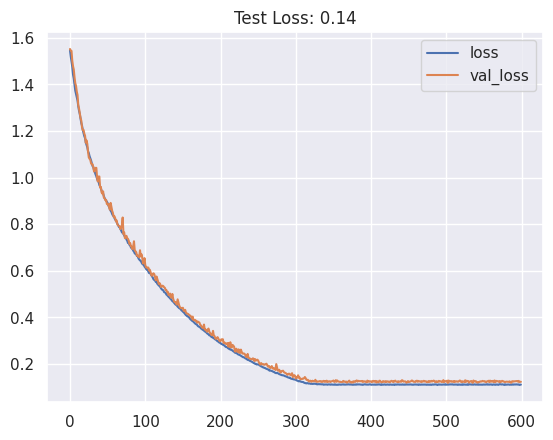

In [110]:
from tqdm import tqdm

history = {
    "loss":[],
    "val_loss":[]
}

model = cnn()
model = model.to(device_)

epochs = 600
lr_ = 0.001

optimizer = optim.Adam(model.parameters(),lr=lr_)
learning_rate = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", factor=0.1, patience=5)
loss_fn = nn.SmoothL1Loss()

l1_lambda = 0
l2_lambda = 0.005

train_loss, val_loss = [], []

for e in tqdm(range(epochs)):

  running_loss = 0.0
  val_running_loss = 0.0
  steps = 0

  for i in range(3):

    indices = torch.randperm(X_train.size()[0])[:train_batch_size]

    x_ = X_train[indices,::].to(torch.float)
    x_ = abs(torch.fft.fft2(x_))
    y_ = y_train[indices,::].to(torch.float)

    x_ = x_.to(device_)
    y_ = y_.to(device_)

    model =model.train()

    optimizer.zero_grad()

    y_est = model(x_)
    y_est = y_est.requires_grad_(True)

    loss = loss_fn(y_est,y_)
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
    loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
    running_loss += loss.item()

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), 1)
    optimizer.step()

    steps += 1

    # if steps == 5:
    #   break

  running_loss /= steps
  history["loss"].append(running_loss)

  val_running_loss = 0.0
  steps = 0

  for i in range(5):

    indices = torch.randperm(X_val.size()[0])[:val_batch_size]

    x_val = X_val[indices,::].to(torch.float)
    x_val = abs(torch.fft.fft2(x_val))
    y_val_ = y_val[indices,::].to(torch.float)

    x_val = x_val.to(device_)
    y_val_ = y_val_.to(device_)

    model = model.eval()
    y_est = model(x_val)

    loss = loss_fn(y_est,y_val_)
    l1_norm = sum(p.abs().sum() for p in model.parameters())
    l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
    loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
    val_running_loss += loss.item()

    steps += 1

    # if steps == 5:
    #   break


  val_running_loss /= steps
  history["val_loss"].append(val_running_loss)

  learning_rate.step(val_running_loss)
  last_lr = learning_rate.get_last_lr()

  print("----------------------------------------------------------------------------------")
  print(f"Epoch: {e}/{epochs} | loss: {running_loss:.2f} |  validation loss: {val_running_loss:.2f} | learning rate: {last_lr}")

model = model.eval()

y_ = model(X_test)
y_test = y_test.requires_grad_(True)

loss = loss_fn(y_test,y_)
l1_norm = sum(p.abs().sum() for p in model.parameters())
l2_norm = sum(((p.abs())**2).sum() for p in model.parameters())
loss = loss + (l1_lambda*l1_norm) + (l2_lambda*l2_norm)
print("------------------------------------------------------------------------------------")
print(f"Test Loss: {loss.item():.2f}")
print("------------------------------------------------------------------------------------")

print("Loss")
print(" ")
import matplotlib.pyplot as plt

plt.plot(history["loss"],label="loss")
plt.plot(history["val_loss"],label="val_loss")

plt.title(f"Test Loss: {loss.item():.2f}")

plt.grid()
plt.legend()



R-squared: 0.30


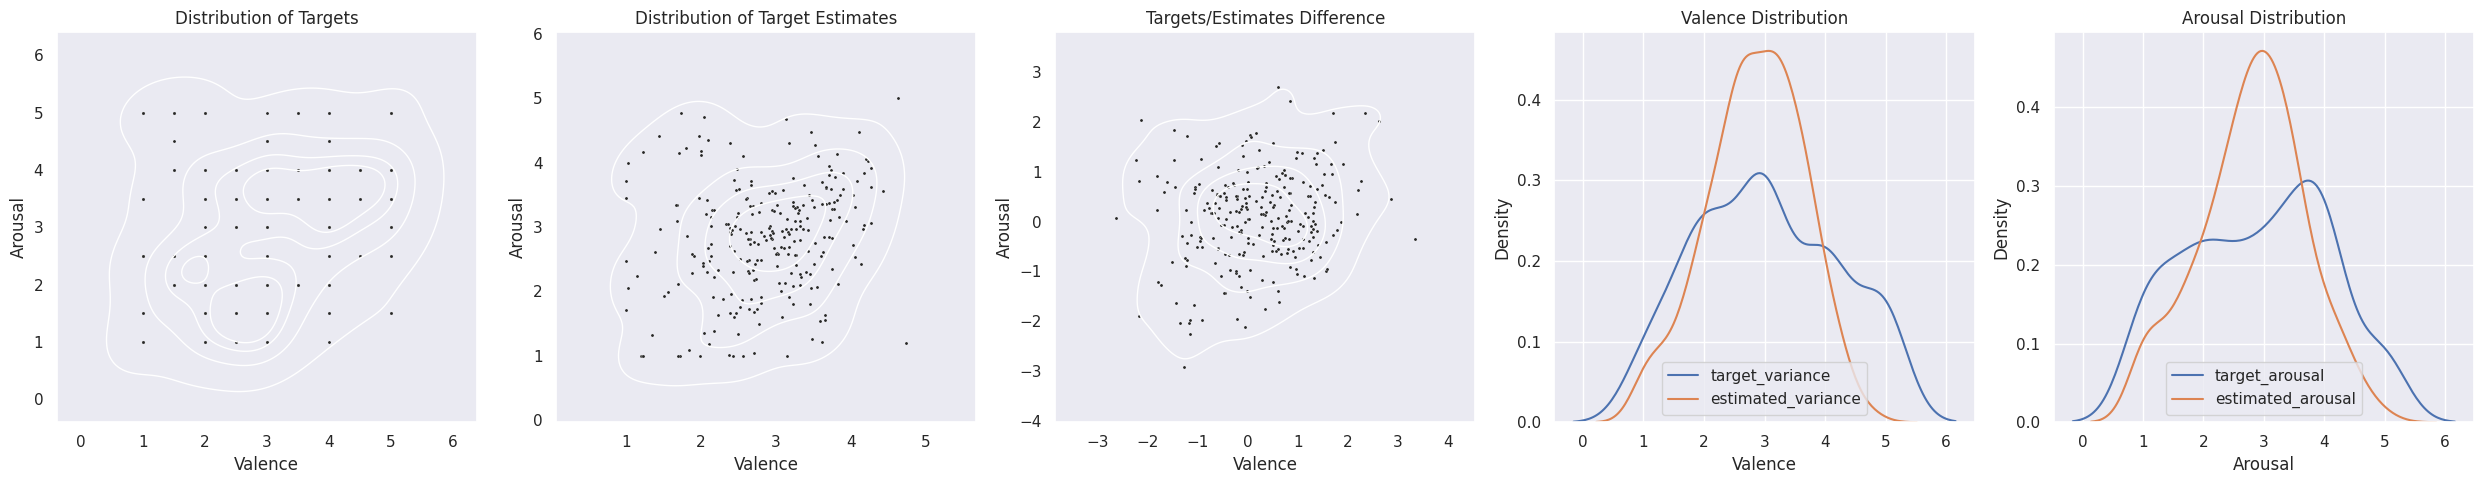

In [111]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

fig, ax_  = plt.subplots(1,5,figsize=(25,5))

# X_test = torch.tensor(X_test).to(float)
# y_test = torch.tensor(y_test).to(float)

y = feature_scaler.inverse_transform(y_test.detach().numpy())

sns.scatterplot(x=y[:,0], y=y[:,1], s=5, color=".15", ax=ax_[0])
# sns.histplot(x=y[:,0], y=y[:,1], bins=50, pthresh=.1, cmap="mako", ax=ax_[0])
sns.kdeplot(x=y[:,0], y=y[:,1], levels=5, color="w", linewidths=1, ax=ax_[0])

model = model.eval()

y_est = model(abs(torch.fft.fft2(X_test)))
y_est = y_est.detach().numpy()
y_est = feature_scaler.inverse_transform(y_est)

sns.scatterplot(x=y_est[:,0], y=y_est[:,1], s=5, color=".15", ax=ax_[1])
# sns.histplot(x=y_est[:,0], y=y_est[:,1], bins=50, pthresh=.1, cmap="mako", ax=ax_[1])
sns.kdeplot(x=y_est[:,0], y=y_est[:,1], levels=5, color="w", linewidths=1, ax=ax_[1])

distance = feature_scaler.inverse_transform(y_test.detach().numpy())-y_est
sns.scatterplot(x=distance[:,0], y=distance[:,1], s=5, color=".15", ax=ax_[2])
# sns.histplot(x=distance[:,0], y=distance[:,1], bins=50, pthresh=.1, cmap="mako", ax=ax_[2])
sns.kdeplot(x=distance[:,0], y=distance[:,1], levels=5, color="w", linewidths=1, ax=ax_[2])

sns.kdeplot(x=y[:,0],ax=ax_[3],label="target_variance")
sns.kdeplot(x=y_est[:,0],ax=ax_[3],label="estimated_variance")

sns.kdeplot(x=y[:,1],ax=ax_[4],label="target_arousal")
sns.kdeplot(x=y_est[:,1],ax=ax_[4],label="estimated_arousal")

ax_[0].set_title("Distribution of Targets")
ax_[0].set_xlabel("Valence")
ax_[0].set_ylabel("Arousal")

ax_[1].set_title("Distribution of Target Estimates")
ax_[1].set_xlabel("Valence")
ax_[1].set_ylabel("Arousal")

ax_[2].set_title("Targets/Estimates Difference")
ax_[2].set_xlabel("Valence")
ax_[2].set_ylabel("Arousal")

ax_[3].set_xlabel("Valence")
ax_[3].set_title("Valence Distribution")
ax_[3].legend()
ax_[3].grid()

ax_[4].set_xlabel("Arousal")
ax_[4].set_title("Arousal Distribution")
ax_[4].legend()
ax_[4].grid()

fig.tight_layout()

print(f"R-squared: {r_squared(model(abs(torch.fft.fft2(X_test))),y_test):.2f}")

Text(0.5, 1.0, 'Correlation of targets and estimates')

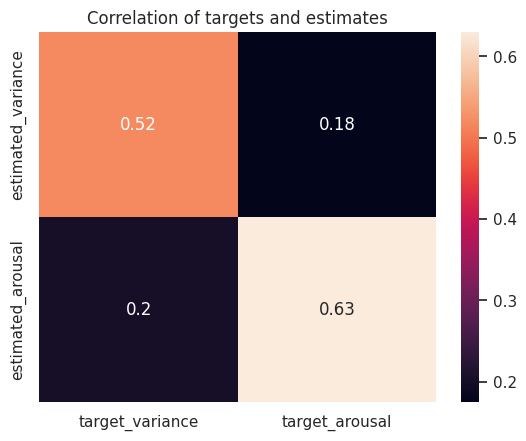

In [112]:
y_est = model(abs(torch.fft.fft2(X_test))).detach().numpy()
y_est = feature_scaler.inverse_transform(y_est)

target = y_test.clone()
target = target.detach().numpy()
target = feature_scaler.inverse_transform(target)

corr_ = np.empty((2,2))

corr_[0,0] = np.corrcoef(
    y_est[:,0],
    target[:,0],
    rowvar=False
)[0,1]

corr_[1,1] = np.corrcoef(
    y_est[:,1],
    target[:,1],
    rowvar=False
)[0,1]

corr_[0,1] = np.corrcoef(
    y_est[:,0],
    target[:,1],
    rowvar=False
)[0,1]

corr_[1,0] = np.corrcoef(
    y_est[:,1],
    target[:,0],
    rowvar=False
)[0,1]

sns.heatmap(corr_,xticklabels=["target_variance","target_arousal"],yticklabels=["estimated_variance","estimated_arousal"],annot=True)
plt.title("Correlation of targets and estimates")

In [113]:
def checkpoint_model(model,name,test_performance):
  model_ = {
      "model":model,
      "model_weights":model.state_dict(),
      "performance":test_performance
  }
  joblib.dump(model_,name)

In [115]:
checkpoint_model(model=model,name="cnn_18.sav",test_performance="0.14 Test MSE Loss")